# Fall detector
## \[5ARB0\] Data Acquisition and Analysis - Technical Assignment

In [1]:
# this cell imports the libraries or packages that you can use during this assignment
# you are not allowed to import additional libraries or packages
from helpers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

In [2]:
# Set global data path variable, change if needed
DATA_PATH = r'C:\Users\20191678\OneDrive - TU Eindhoven\5ARB0 - DS for AI\5ARB0-2023-falldetector-student\data'

> **Important**
>
> Do not import any other packages or libraries than the ones already provided to you.
>
> Write your code between the `BEGIN_TODO` and `END_TODO` markers. Do not change these markers.
>
> Restart your notebook and run all cells before submission.

## Introduction
In this assignment you will use the previously learned data analysis methods and apply them to create a fall detector. After collecting and preprocessing sensor recording, you will extract a set of features which you will use for creating a fall detector.

This assignment is split into 4 parts. Parts 1-3 encompass the collection, preprocessing and feature extraction of sensor recordings. Finally, in part 4 you will create a fall detector.

### Learning goals
After this assignment you can
- collect data according to a protocol;
- load and merge datasets;
- preprocess data;
- extract features from data;
- apply analysis methods for creating a fall detector.

## Part 1: Data collection

Collect the data according to the data collection protocol provided on Canvas.

> (For iPhone) If you have issues accessing the (live) calibrated data of the _Sensor Logger_ app, you need to enable motion and compas calibration on your phone as explained [here](https://www.lifewire.com/how-to-calibrate-an-iphone-4172146). You will notice this once the live view and the export yield empty results.

## Part 2: Data cleaning and preprocessing
In this part you will be working on cleaning and preprocessing the data that you have gathered for further analysis.


---
---
### Exercise 2.1: Read, merge and select data
Load one of your individuals recordings in a Pandas DataFrame called `data`. You may want to have a look at the `pd.merge_asof` function to combine the recordings of the different sensors. Make sure that the `data` dataframe does not contain any `NaN`'s or empty fields as a result of different sampling frequencies. Any columns/recordings that you will not be using in your experiment should be removed from `data` (except for the `seconds_elapsed` column). Also remove duplicate colums. In the end your dataframe should have an indexing column, a column called `seconds_elapsed`, followed by the columns corresponding to the measurements.

In [3]:
# Function to process a single recording folder
def process_recording(directory):
    """
    Process a single recording folder and return a single DataFrame

    Args:
        directory (str): Path to the recording folder

    Returns:    
        merged_data (DataFrame): A single DataFrame containing all sensor data from the recording
    """
    # Specify files of interest
    files = ['Accelerometer.csv', 'Gyroscope.csv', 'Gravity.csv']

    # Create an empty list to store DataFrames from each CSV file
    dataframes = []

    # Loop through the files in the directory and read each CSV file into a DataFrame
    for filename in files:
        filepath = directory + '/' + filename
        try:
            df = pd.read_csv(filepath)
            if not df.empty:
                if 'time' in df.columns:
                    # Only keep 'time' column in the first DataFrame
                    if not dataframes:
                        dataframes.append(df)
                    else:
                        dataframes.append(df.drop(columns='seconds_elapsed'))
        except pd.errors.EmptyDataError:
            print(f"Skipping empty file: {filename}")

    # Merge the DataFrames using the 'time' column as the key
    merged_data = dataframes[0].set_index('time')

    for i, df in enumerate(dataframes[1:], start=2):
        if 'time' in df.columns:
            # Specify custom suffixes for columns to avoid duplicates
            suffix = f'_{i}'
            merged_data = pd.merge_asof(merged_data, df.set_index('time'), on='time', suffixes=('', suffix))

    merged_data.drop(columns='time', inplace=True)
    # Fill NaN values with the mean of each corresponding column
    merged_data = merged_data.apply(lambda col: col.fillna(col.mean()))

    return merged_data

In [4]:
#// BEGIN_TODO [5ARB0_FallDetector_2_1] Read, merge and select data

# Specify subpath to recording folder
subpath = r"\Luciano\Fall 1"

# Read, merge and select data
data_merged = process_recording(DATA_PATH + subpath)
data_merged.columns

#// END_TODO [5ARB0_FallDetector_2_1]

Index(['seconds_elapsed', 'z', 'y', 'x', 'z_2', 'y_2', 'x_2', 'z_3', 'y_3',
       'x_3'],
      dtype='object')

### End of exercise 2.1
---
---

In order to restrict our focus to fall detection, we would like to trim the recorded segment. In this way we can remove the movements corresponding to starting and stopping the sensor logger app.

---
---
### Exercise 2.2: Trim data
Remove the first and last 5 seconds of the recordings for this purpose and save this trimmed data frame to `data_trimmed`. Make sure that your code works for a data frame containing an arbitrary number of columns.

In [5]:
def trim_data(data):
    # Trimming data by removing the first and last 5 seconds
    sampling_rate = 1 / (data['seconds_elapsed'].iloc[1] - data['seconds_elapsed'].iloc[0])
    trim_duration = 5  # seconds
    trim_rows = int(sampling_rate * trim_duration)

    data_trimmed = data.iloc[trim_rows:-trim_rows]
    return data_trimmed

In [6]:
#// BEGIN_TODO [5ARB0_FallDetector_2_2] Trim data

data_trimmed = trim_data(data_merged)
data_trimmed.columns

#// END_TODO [5ARB0_FallDetector_2_2]

Index(['seconds_elapsed', 'z', 'y', 'x', 'z_2', 'y_2', 'x_2', 'z_3', 'y_3',
       'x_3'],
      dtype='object')

### End of exercise 2.2
---
---

---
---
### Exercise 2.3: Normalize recordings
For improved processing, the recordings should be normalized. Normalize the recordings by subtracting its mean and by then dividing by its standard deviation. Perform this normalization for each column individually. Save your normalized data in the the data frame `data_norm`.

In [7]:
def normalize_data(data):
    # Normalize the specified sensor data columns in place using .iloc
    data_norm = data.copy()
    data_norm.iloc[:, 1:] = (data_norm.iloc[:, 1:] - data_norm.iloc[:, 1:].mean()) / data_norm.iloc[:, 1:].std()
    return data_norm

In [8]:
#// BEGIN_TODO [5ARB0_FallDetector_2_3] Normalize recordings

data_norm = normalize_data(data_trimmed)

#// END_TODO [5ARB0_FallDetector_2_3]

### End of exercise 2.3
---
---

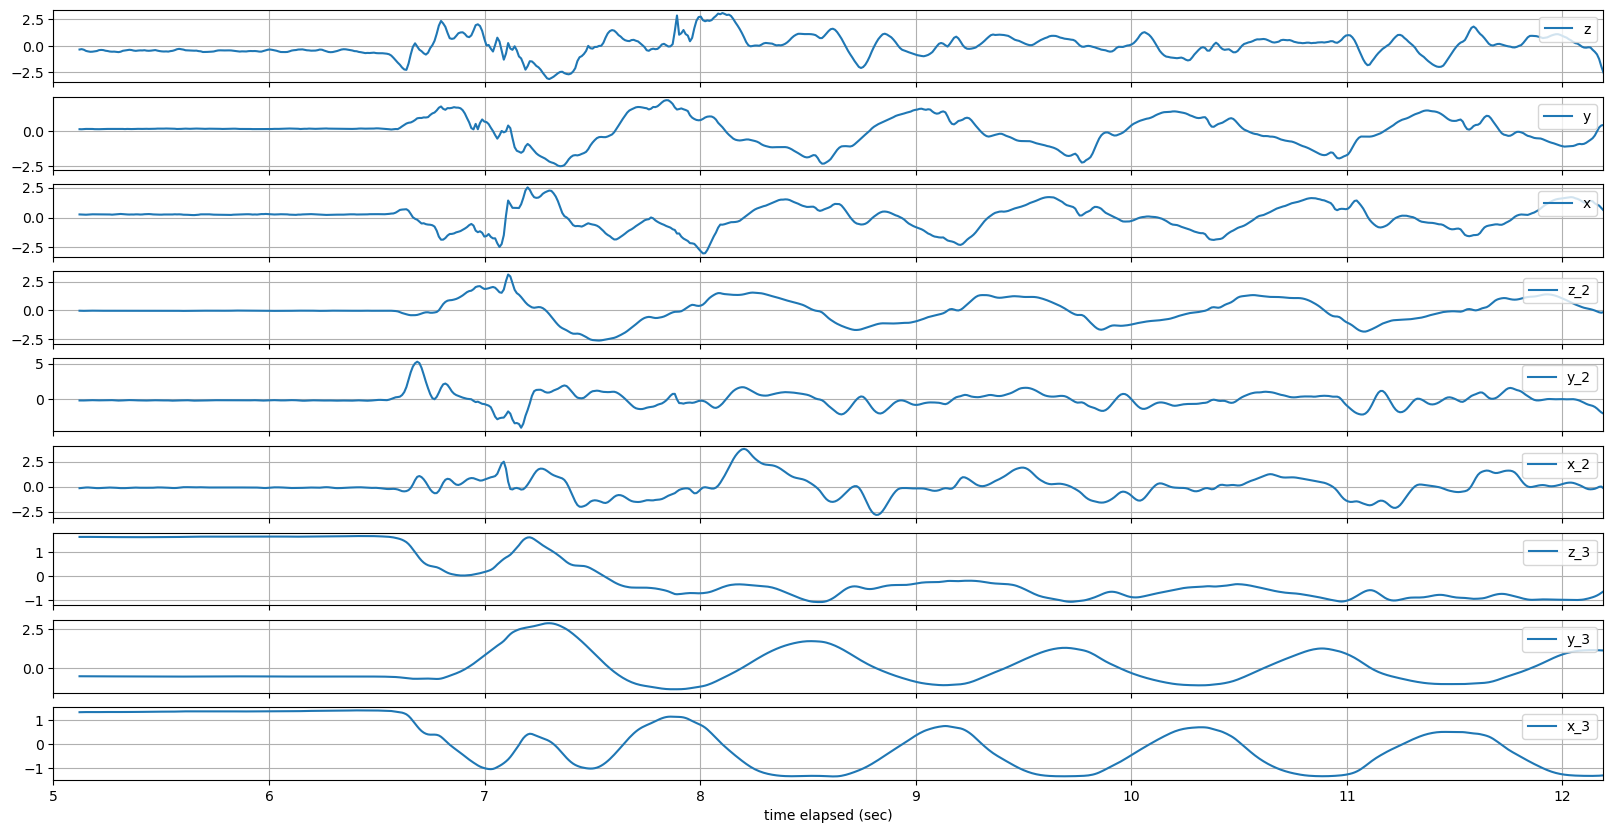

In [9]:
# plot recordings
ex2_plot_data(data_norm)

## Part 3: Feature extraction
The current data is not yet suited for detecting a fall. Based on the measurements at a specific point of time, it is difficult to determine whether someone has allen. Instead, it would be more appropriate to perform the fall detection over _segments_ of time. In this part you will extract features that will be used for detecting falls. But first all collected datasets will be processed.

---
---
### Exercise 3.1: Merge all datasets
Before starting the feature extraction, merge all the preprocessed datasets obtained in the protocol. You will need to load all recording, and again perform all preprocessing steps of Part 2 for the individual recordings. Make sure your code adheres to proper coding standards (make it look nice, don't copy part 2 15 times). Save your merged data in the the data frame `data_merged`.

In [27]:
def batch_process_recordings(directory):
    """
    Process all recordings in the specified directory and return a single DataFrame

    Args:
        directory (str): Path to the directory containing the recording folders

    Returns:
        data_merged (DataFrame): A single DataFrame containing all processed recordings with a MultiIndex
    """
    
    # Create an empty list to store processed DataFrames for each recording
    processed_dataframes = []

    # Iterate through the recording folders and process each one
    for user_folder in os.listdir(directory):
        print(f"Processing user: {user_folder}")
        user_path = os.path.join(directory, user_folder)
        if os.path.isdir(user_path):
            for recording_folder in os.listdir(user_path):
                print(f"\tProcessing recording: {recording_folder}")
                recording_path = os.path.join(user_path, recording_folder)
                if os.path.isdir(recording_path):
                    processed_df = process_recording(recording_path)
                    if not processed_df.empty:
                        trimmed_df = trim_data(processed_df)   
                        normalized_df = normalize_data(trimmed_df) 
                        # Append a tuple containing the User and Recording index values along with the DataFrame
                        processed_dataframes.append((user_folder, recording_folder, normalized_df))
                
    # Create a MultiIndex from the User and Recording index values in the processed_dataframes list
    multi_index = pd.MultiIndex.from_tuples([(item[0], item[1]) for item in processed_dataframes], names=['User', 'Recording'])

    # Create a DataFrame from the processed DataFrames and MultiIndex
    data_merged = pd.concat([item[2] for item in processed_dataframes], keys=multi_index)

    return data_merged

In [28]:
#// BEGIN_TODO [5ARB0_FallDetector_3_1] Merge all datasets

# Process and combine all recordings into a single DataFrame
data_merged = batch_process_recordings(DATA_PATH)

# Define a dictionary with the new column names
new_column_names = {
    "z": "acc_z",
    "y": "acc_y",
    "x": "acc_x",
    "z_2": "gyro_z",
    "y_2": "gyro_y",
    "x_2": "gyro_x",
    "z_3": "grav_z",
    "y_3": "grav_y",
    "x_3": "grav_x",
}

# Rename the columns using the dictionary
data_merged = data_merged.rename(columns=new_column_names)


data_merged.head()

#// END_TODO [5ARB0_FallDetector_3_1]

Processing user: Abdu
	Processing recording: Fall 1
	Processing recording: Fall 2
	Processing recording: Fall 3
	Processing recording: Fall 4
	Processing recording: Fall 5
	Processing recording: Sit 1
	Processing recording: Sit 2
	Processing recording: Sit 3
	Processing recording: Sit 4
	Processing recording: Sit 5
	Processing recording: Stand 1
	Processing recording: Stand 2
	Processing recording: Stand 3
	Processing recording: Stand 4
	Processing recording: Stand 5
Processing user: Anas
	Processing recording: Fall 1
	Processing recording: Fall 2
	Processing recording: Fall 3
	Processing recording: Fall 4
	Processing recording: Fall 5
	Processing recording: Sit 1
	Processing recording: Sit 2
	Processing recording: Sit 3
	Processing recording: Sit 4
	Processing recording: Sit 5
	Processing recording: Stand 1
	Processing recording: Stand 2
	Processing recording: Stand 3
	Processing recording: Stand 4
	Processing recording: Stand 5
Processing user: Luciano
	Processing recording: Fall 1
	

seconds_elapsed     acc_z     acc_y     acc_x    gyro_z  \
User Recording                                                                
Abdu Fall 1    498         5.020314  0.037317 -0.982982 -0.627976  0.324277   
               499         5.030335  0.100264 -1.151053 -0.705782  0.294590   
               500         5.040355  0.240631 -1.324769 -0.760590  0.252026   
               501         5.050376  0.141851 -1.479807 -0.805791  0.212442   
               502         5.060396  0.035781 -1.521464 -0.887969  0.146667   

                      gyro_y    gyro_x    grav_z    grav_y    grav_x  
User Recording                                                        
Abdu Fall 1    498 -0.257316  0.352696 -0.444729  0.380816  0.173671  
               499 -0.282679  0.431699 -0.456178  0.393854  0.189415  
               500 -0.351941  0.457235 -0.470330  0.405053  0.203429  
               501 -0.507807  0.472649 -0.480286  0.414086  0.214667  
               502 -0.648837  0.507555 -0.484328  0.420483  0.222385

Text(0.5, 0, 'time elapsed (sec)')

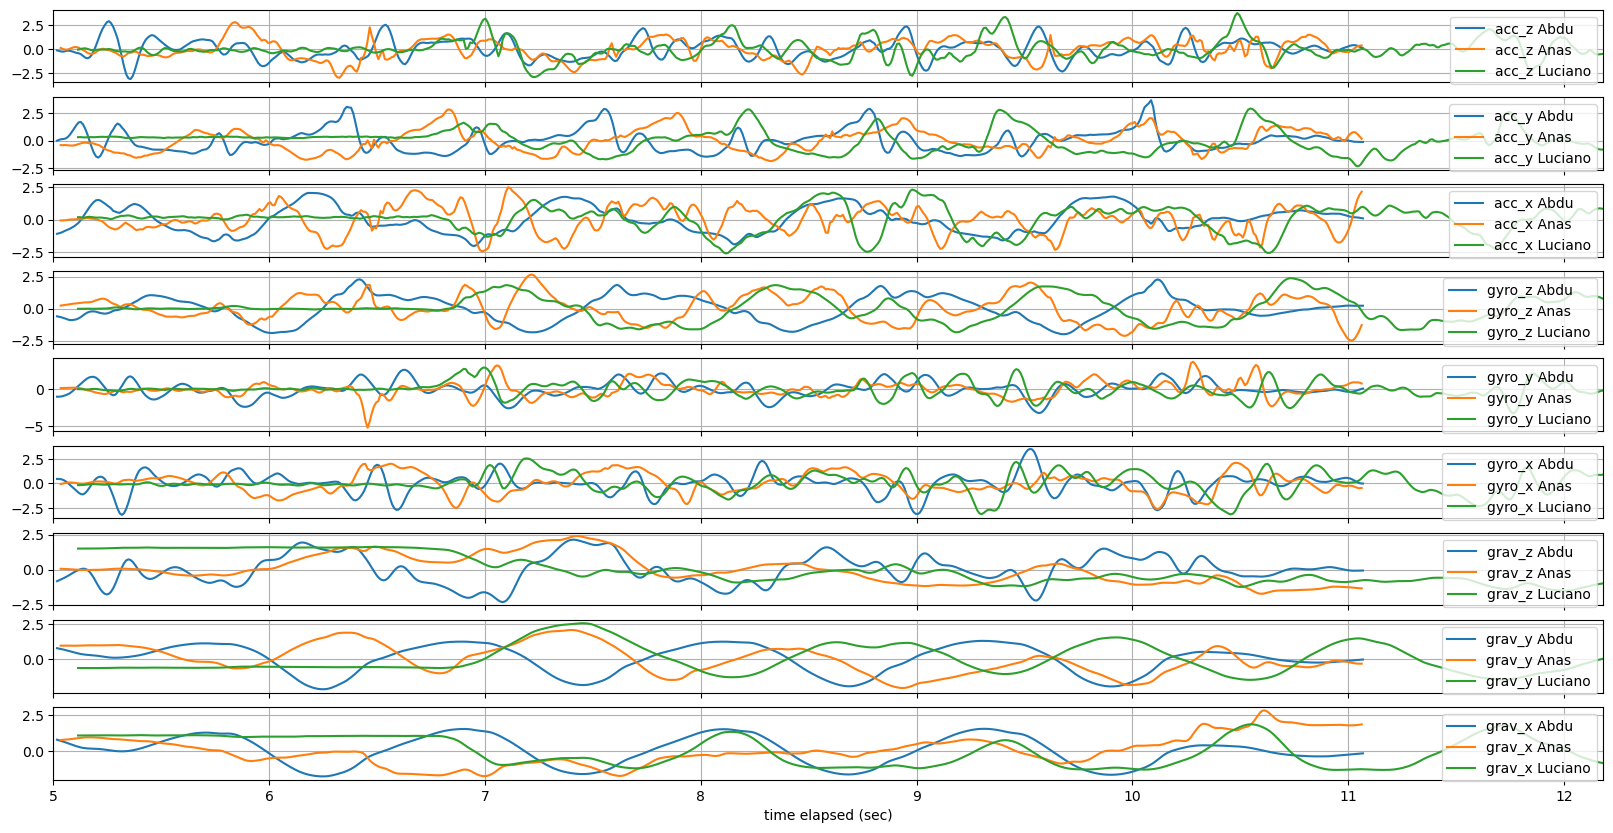

In [29]:
# Plot single Stand recording to see variance in both sensor and person data

fig, ax = plt.subplots(nrows=len(data_merged.columns)-1, figsize=(20,10), sharex=True)

for ind, column in enumerate(data_merged.columns[1:]):
    for person in data_merged.index.levels[0]:
        data = data_merged.loc[(person, "Stand 5")]
        ax[ind].plot(data["seconds_elapsed"], data[column], label=column + ' ' + person)
    ax[ind].set_xlim(5, data_merged.loc[(person, "Stand 5")]["seconds_elapsed"].iloc[-1])
    ax[ind].legend(loc="upper right")
    ax[ind].grid(True)

ax[-1].set_xlabel("time elapsed (sec)")

Text(0.5, 0, 'time elapsed (sec)')

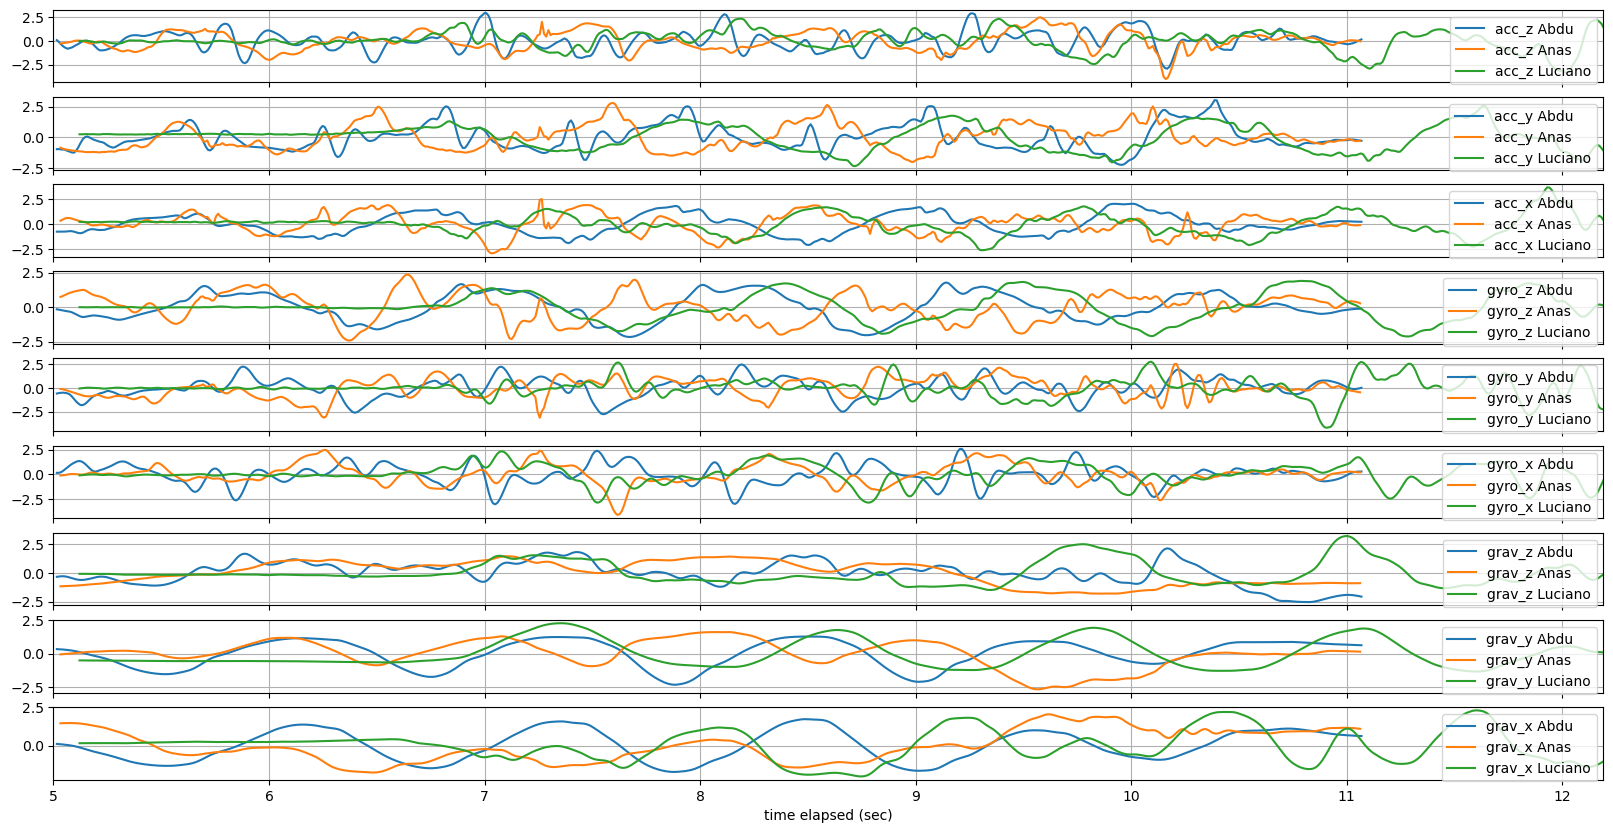

In [30]:
# Plot single Fall recording to see variance in both sensor and person data

fig, ax = plt.subplots(nrows=len(data_merged.columns)-1, figsize=(20,10), sharex=True)

for ind, column in enumerate(data_merged.columns[1:]):
    for person in data_merged.index.levels[0]:
        data = data_merged.loc[(person, "Fall 5")]
        ax[ind].plot(data["seconds_elapsed"], data[column], label=column + ' ' + person)
    ax[ind].set_xlim(5, data_merged.loc[(person, "Fall 5")]["seconds_elapsed"].iloc[-1])
    ax[ind].legend(loc="upper right")
    ax[ind].grid(True)

ax[-1].set_xlabel("time elapsed (sec)")

### End of exercise 3.1
---
---

---
---
### Exercise 3.2: Convert data frame to matrix
In order to extract features from the recording, first convert the dataframe to a Numpy matrix called `mat`. This matrix should have dimensions (_nr of time points_, _nr or different recordings_). Make sure that you remove the _seconds_elapsed_ column, as this does not yield any useful information for the fall detector.

In [31]:
#// BEGIN_TODO [5ARB0_FallDetector_3_2] Convert data frame to matrix

#Create a function to convert the DataFrame to a NumPy matrix
def to_matrix(df):
    return df.iloc[:, 1:].to_numpy()

# Convert the DataFrame to a NumPy matrix with dimensions (number of time points, number of different recordings)
mat = to_matrix(data_merged)

# Verify the shape of the matrix
print("Shape of mat:", mat.shape)

#// END_TODO [5ARB0_FallDetector_3_2]

Shape of mat: (27899, 9)


### End of exercise 3.2
---
---

Now that the data frame has been converted to a matrix, it can be split into different overlapping segments, of which we can extract features. As a starting point we will specify features as the mean value of a segment, its standard deviation, its minimum and its maximum.

---
---
### Exercise 3.3: Processing segments
Create a function `Y = process_segment(mat, fun, L, K)` that processes time segments of the matrix `mat`. The argument `fun` specifies the operation to be performed on the segment and its value comes from the set `["mean", "std", "minimum", "maximum"]`. `L` specifies the segment length and `K` specifies the number of samples overlap between segments. The function should return a matrix `Y` with dimensions (_nr of segments_, _nr of different recordings_)

In [32]:
#// BEGIN_TODO [5ARB0_FallDetector_3_3] Process segments

def process_segment(mat, fun, L, K):
    """
    Processes time segments of the matrix `mat`.

    Parameters:
    mat (ndarray): Input matrix of shape (n_samples, n_features).
    fun (str): Operation to be performed on the segment.
    L (int): Segment length.
    K (int): Number of samples overlap between segments.

    Returns:
    ndarray: Output matrix of shape (n_segments, n_features).
    """

    # Define a dictionary mapping function names to functions
    func_map = {
        "mean": np.mean,
        "std": np.std,
        "minimum": np.min,
        "maximum": np.max,
        "variance": np.var,
        "median": np.median,
        "range": np.ptp,
        "sma": lambda x: np.sum(np.abs(x)),
        "energy": lambda x: np.sum(x**2),
    }

    # Get the function corresponding to the specified function name
    func = func_map.get(fun, None)
    # Raise an error if the function name is invalid
    if func is None:
        raise ValueError(f"Invalid value for fun: {fun}")

    # Split the matrix into segments of length L with K samples overlap
    segments = [mat[i:i+L] for i in range(0, mat.shape[0]-L+1, K)]

    # Apply the specified function to each segment
    Y = np.apply_along_axis(func, 1, segments)

    return Y

#// END_TODO [5ARB0_FallDetector_3_3]

In [72]:
Y_mean = process_segment(mat, "mean", 100, 50)
Y_std = process_segment(mat, "std", 100, 50)
Y_minimum = process_segment(mat, "minimum", 100, 50)
Y_maximum = process_segment(mat, "maximum", 100, 50)

Y_variance = process_segment(mat, "variance", 100, 50)
Y_median = process_segment(mat, "median", 100, 50)
Y_range = process_segment(mat, "range", 100, 50)
Y_sma = process_segment(mat, "sma", 100, 50)
Y_energy = process_segment(mat, "energy", 100, 50)

### End of exercise 3.3
---
---

---
---
### Exercise 3.4: Concatenate features
Now that you have computed some features of the recordings, it becomes necessary to combine them into a single matrix. Create the matrix `features` which concatenates the above results along the appropriate axis.

In [75]:
#// BEGIN_TODO [5ARB0_FallDetector_3_4] Concatenate features

# Concatenate along the second axis (columns)
def concatenate_features(*args):
    return np.concatenate(args, axis=1)

features = concatenate_features(Y_mean, Y_std, Y_minimum, Y_maximum, Y_variance)

features.shape
#// END_TODO [5ARB0_FallDetector_3_4]

(556, 45)

### End of exercise 3.4
---
---

## Part 4: Fall detector
In this part of the assignment we will use the previously implemented data analysis methods to create a simple fall detector. You will be given more freedom to experiment with the different techniques used.

During this part you can make use of the `sklearn` (Scikit learn) package. This package offers some benefits over the handwritten clustering functions. These algorithms are numerically stable and better optimized to run on large data sets.

In [35]:
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

---
---
### Exercise 4.1: Fall detector
In this assignment you will create your own fall detector, using the previously recorded data and learned data analysis methods. You are free to add more features to the dataset if you want. Possible steps include: 1) feature extraction, 2) data compression and 3) clustering.

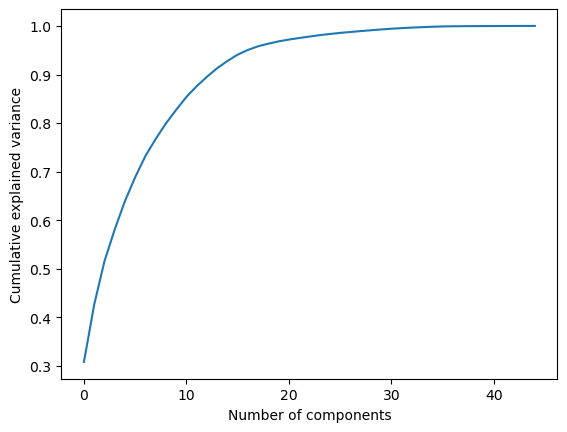

Optimal number of components: 37


c:\Users\20191678\AppData\Local\anaconda3\envs\Assignment1\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\20191678\AppData\Local\anaconda3\envs\Assignment1\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


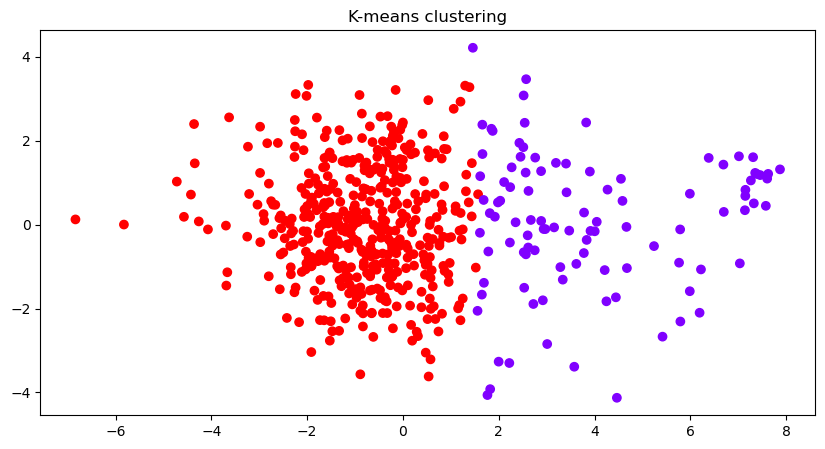

In [77]:
#// BEGIN_TODO [5ARB0_FallDetector_4_1] Fall detector

# Find optimal number of compontents for PCA explained variance threshold
threshold = 0.999
mock_pca = PCA()
mock_pca.fit(features)
plt.plot(np.cumsum(mock_pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

optimal_n_components = np.argmax(np.cumsum(mock_pca.explained_variance_ratio_) > threshold) + 1
print(f"Optimal number of components: {optimal_n_components}")

# Feature extraction with PCA
pca = PCA(n_components=optimal_n_components)
features_pca = pca.fit_transform(features)

# K-means Clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(features_pca)

# K-means Plotting
plt.figure(figsize=(10, 5))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.title("K-means clustering")
plt.show()

#// END_TODO [5ARB0_FallDetector_4_1]

c:\Users\20191678\AppData\Local\anaconda3\envs\Assignment1\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Iteration 1/100, Log-Likelihood: -10.74
Iteration 2/100, Log-Likelihood: -10.74
Iteration 3/100, Log-Likelihood: -10.74
Iteration 4/100, Log-Likelihood: -10.74
Iteration 5/100, Log-Likelihood: -10.74
Iteration 6/100, Log-Likelihood: -10.74
Iteration 7/100, Log-Likelihood: -10.74
Iteration 8/100, Log-Likelihood: -10.74
Iteration 9/100, Log-Likelihood: -10.74
Iteration 10/100, Log-Likelihood: -10.74
Iteration 11/100, Log-Likelihood: -10.74
Iteration 12/100, Log-Likelihood: -10.74
Iteration 13/100, Log-Likelihood: -10.74
Iteration 14/100, Log-Likelihood: -10.74
Iteration 15/100, Log-Likelihood: -10.74
Iteration 16/100, Log-Likelihood: -10.74
Iteration 17/100, Log-Likelihood: -10.74
Iteration 18/100, Log-Likelihood: -10.74
Iteration 19/100, Log-Likelihood: -10.74
Iteration 20/100, Log-Likelihood: -10.74
Iteration 21/100, Log-Likelihood: -10.74
Iteration 22/100, Log-Likelihood: -10.74
Iteration 23/100, Log-Likelihood: -10.74
Iteration 24/100, Log-Likelihood: -10.74
Iteration 25/100, Log-Lik

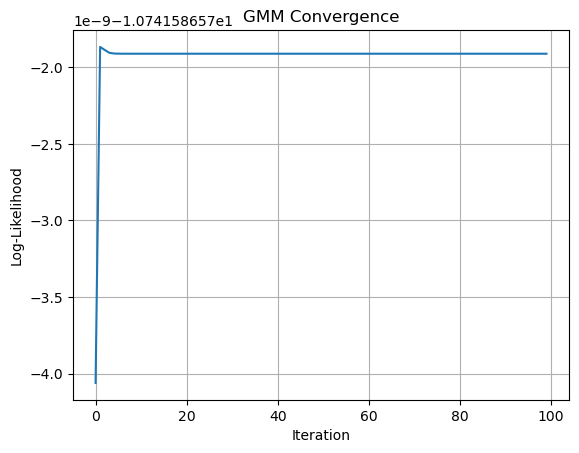

556
12
[1 1 1 1 1 1 1 1 1 1 1 0]
[0 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 0 0 0 1 1]
[1 1 1 1 0 1 0 0 1 1 1 1]
[1 1 0 0 0 0 1 1 1 1 1 1]
[1 1 0 0 0 0 0 0 1 1 1 1]
[1 1 0 1 0 0 0 1 1 1 1 1]
[1 1 1 1 1 0 0 0 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 0 0]
[1 1 1 1 1 1 1 0 1 1 1 1]
[0 1 1 1 1 1 1 1 1 1 0 0]
[0 1 1 1 1 1 1 1 1 1 1 0]
[0 0 1 1 1 1 1 1 1 1 1 1]
[1 0 0 1 1 1 1 1 1 1 1 1]
[0 0 0 0 1 1 1 1 1 1 1 1]
[1 1 1 0 0 0 1 1 1 1 1 1]
[1 1 1 1 0 0 1 1 1 1 1 1]
[1 1 1 0 0 0 1 1 1 1 1 1]
[1 1 1 0 1 1 0 0 1 1 1 1]
[1 1 1 1 1 0 1 1 1 1 1 1]
[1 1 1 1 0 0 1 1 1 1 1 1]
[1 1 1 0 0 1 1 1 1 1 1 1]
[1 1 1 1 0 0 0 0 1 1 1 1]
[1 1 1 1 1 0 0 1 1 1 1 1]
[1 1 1 1 1 0 0 0 0 1 1 1]
[1 1 1 1 1 1 1 0 0 0 0 1]
[1 1 1 1 1 1 1 1 1 1 1 0]
[0 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 1 1 1 1 1 1 1 1 1]
[1 1 0 0 0 0 1 1 1 1 1 1]
[1 1 1 1 1 0 0 0 1 1 1 1]
[1 1 1 1 1 1 1 0 0 1 1 1]
[1 1 1 1 1 1 0 0 0 0 1 1]
[1 1 

In [78]:
#// BEGIN_TODO [5ARB0_FallDetector_4_1] Fall detector

# Initialize the GMM with a specified number of components
gmm = GaussianMixture(n_components=2, random_state=0, warm_start = True, init_params='kmeans')

# Training parameters
num_iterations = 100
log_likelihoods = []

# Training loop
for i in range(num_iterations):
    # Fit the GMM to the data
    gmm.fit(features_pca)

    # Calculate the log-likelihood of the data given the current model
    log_likelihood = gmm.score(features_pca)
    log_likelihoods.append(log_likelihood)

    print(f"Iteration {i + 1}/{num_iterations}, Log-Likelihood: {log_likelihood:.2f}")

# Create the convergence plot
plt.plot(log_likelihoods)
plt.title('GMM Convergence')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.grid(True)

# Show the plot
plt.show()

labels_gmm = gmm.predict(features_pca)

#print(labels_gmm)
print(len(labels_gmm))
dd = int(len(labels_gmm)/45)
print(dd)
for i in range(0, len(labels_gmm), dd):
    print(labels_gmm[i:i+dd])

#// END_TODO [5ARB0_FallDetector_4_1]

### End of exercise 4.1
---
---

---
---
### Exercise 4.2: Fall classification
Use your fall detector to classify when someone has fallen. Plot your fall classification over time.

Number of falls predicted: 114
Fraction of total segments: 0.20503597122302158


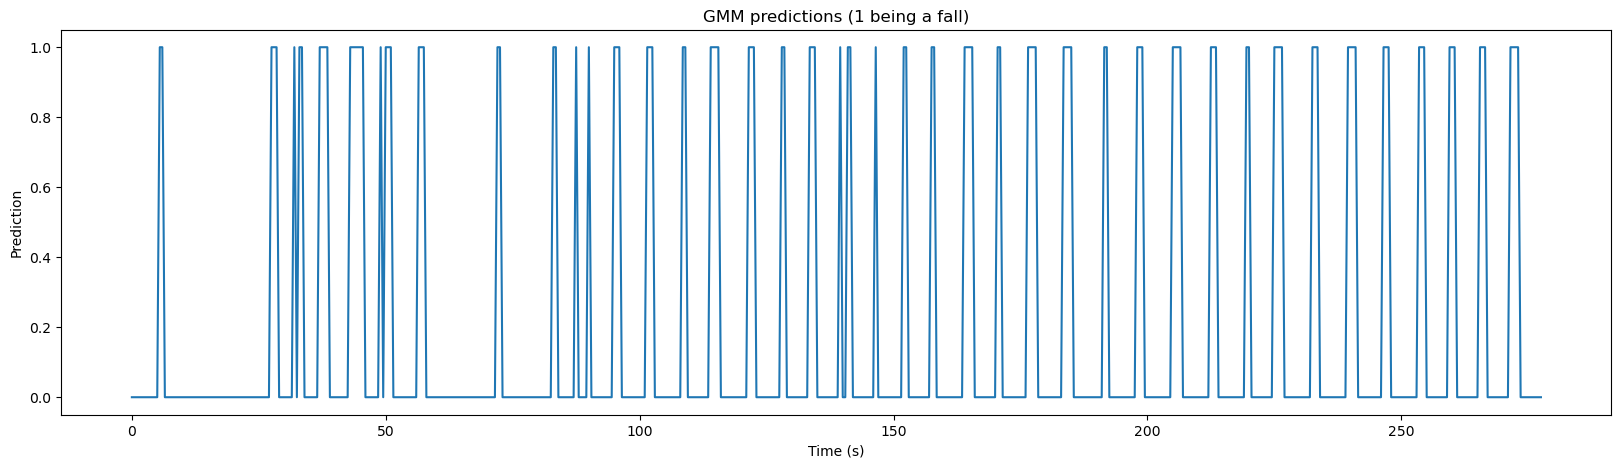

In [79]:
#// BEGIN_TODO [5ARB0_FallDetector_4_2] Classify falls

# Create a time array that corresponds to the time of each row in features
time = np.arange(0, len(features) * 0.5, 0.5)

# Make GMM predictions for each row of features
predictions = [gmm.predict(row.reshape(1, -1))[0] for row in features_pca]

# Invert the predictions
inverted_predictions = [1 - pred for pred in predictions]

# Count the number of 1s in the inverted predictions
num_ones = inverted_predictions.count(1)

# Print the number of 1s
print("Number of falls predicted:", num_ones)
print("Fraction of total segments:", num_ones / len(inverted_predictions))

# Show plot of inverted predictions over time
plt.figure(figsize=(20, 5))
plt.plot(time, inverted_predictions)
plt.title("GMM predictions (1 being a fall)")
plt.xlabel("Time (s)")
plt.ylabel("Prediction")
plt.show()



#// END_TODO [5ARB0_FallDetector_4_2]

In [82]:
# Loop through each unique combination of user and recording in the multiindex
for user, recording in data_merged.index.unique():
    # Select only the data for the current user and recording
    features = data_merged.loc[(user, recording), :]

    # Convert the DataFrame to a NumPy matrix
    user_recording_data_mat = to_matrix(features)

    # Process the matrix into features
    Y_mean = process_segment(user_recording_data_mat, "mean", 100, 50)
    Y_std = process_segment(user_recording_data_mat, "std", 100, 50)
    Y_minimum = process_segment(user_recording_data_mat, "minimum", 100, 50)
    Y_maximum = process_segment(user_recording_data_mat, "maximum", 100, 50)
    Y_variance = process_segment(user_recording_data_mat, "variance", 100, 50)

    # Concatenate the features
    features = concatenate_features(Y_mean, Y_std, Y_minimum, Y_maximum, Y_variance)
    
    # Create a time array that corresponds to the time of each row in the data
    time = np.arange(0, len(features) * 0.5, 0.5)
    
    # Make GMM predictions for each row of the data
    predictions = [gmm.predict(row.reshape(1, -1))[0] for row in features.values]
    
    # Invert the predictions
    inverted_predictions = [1 - pred for pred in predictions]
    
    # Count the number of 1s in the inverted predictions
    num_ones = inverted_predictions.count(1)
    
    # Print the number of 1s
    print("Number of falls predicted for user", user, "recording", recording, ":", num_ones)
    print("Fraction of total segments for user", user, "recording", recording, ":", num_ones / len(inverted_predictions))
    
    # Show plot of inverted predictions over time
    plt.figure(figsize=(20, 5))
    plt.plot(time, inverted_predictions)
    plt.title("GMM predictions for user " + user + ", recording " + recording + " (1 being a fall)")
    plt.xlabel("Time (s)")
    plt.ylabel("Prediction")
    plt.show()

ValueError: too many values to unpack (expected 2)

### End of exercise 4.2
---
---

---
---
### Exercise 4.3: Classification improvements
You might have noticed that it is not easy to create a fall detector. How do you think that you could improve the performance? Please carefully describe the current flaws and ways to deal with them, together with a list of next steps that you would take. Please elaborate on your answer.

*Currently, we are trying to make a classification on only a segment of the fall detector recording time series. Although we use aggregation functions over a time segment, this introduces bias to the model. By the bias/variance tradeoff rule this decreases variance wich may lead to an underfitting model. For example segment of a falling motion can be identical to segments of a sitting motion, which can not be seperated by the model in a unsupervised classification. Improving the models complexity to include classification over a larger time window can increase the accuracy of the model. Examples are models like RNNs, LSTMs or GRUs mainly developed for time-series classification or even Transformer based models that can handle both spatial and temporal information quite accurately.*

*Additionally, due too the nature of how we created the segments with an overlap K, the changes are very high that 1 segment contains both falling and non-falling behaviour. To solve this one needs to estimate the expected falling duration, tweak the segment lenght to that size and use a sliding window. This maximizes the change of isolating the particular falling motion in 1 segment.*

*Next, increasing the size of the dataset should increase the accuracy of the model. There dataset contains 45 actions with one third of them falling, one third is sitting, and one third is standing. Taking the nature of these records into consideration; as 3/4 of each action is actually walking; we can conclude is kind of skewed. Without furhter preproccessing the data would contain very few instances of an actual falling event.*

### End of exercise 4.3
---
---

>   Make sure to restart this notebook and to rerun all cells before submission to check whether all code runs properly.